In [1]:
# remove the notebook root logger.\n",
import logging
logger = logging.getLogger()
logger.handlers = []

## Exogenous Variables with PyAF

PyAF allows using some external sources to improve its forecasts. 

In addition to the training dataset, the user can provide an external table with exogenous variables data. This table is merged with the signal dataset when exogenous vairables values are need (either when training the model or when  producing forecasts).

The signal and exogenous variables can come from the same table (self-join).




### Exogenous variables Modeling

All PyAF models are of the form of a linear decomposition (Trend + Periodic + AR). The exogenous avriables are introduced in the AR component through thier past values.


Before working with exogenous variables, they need to be first transformed into a numerical form (encoed). PyAF used standrd encoding procedures. Non-numerical exogenous variables are dummified (a binary column is created for each distinct column value) and numericcal columns are stadanrdiozed ( Y = (X-m)/s , where m is the mean and s is the standard deviation) 

### Example with Ozone dataset

For demosntration puroposes, we tranform the Loas Angeles ozone dataset so that it contains some exogenous variables. In a real case, these variables can provide some information on Los Angeles (population , temperature, ...) on the same period.

Here, 4 variables have been created artificially.

In [2]:
import numpy as np
import pandas as pd
import datetime

csvfile_link = "https://raw.githubusercontent.com/antoinecarme/pyaf/master/data/ozone-la-exogenous-2.csv"
exog_dataframe = pd.read_csv(csvfile_link);
exog_dataframe['Date'] = exog_dataframe['Date'].astype(np.datetime64);

print(exog_dataframe.info())
exog_dataframe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    216 non-null    datetime64[ns]
 1   Exog2   216 non-null    int64         
 2   Exog3   216 non-null    int64         
 3   Exog4   216 non-null    object        
 4   Exog5   216 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 8.6+ KB
None


,Date,Exog2,Exog3,Exog4,Exog5
0,1955-01-01,2,3,F,M
1,1955-02-01,3,5,G,L
2,1955-03-01,5,6,G,L
3,1955-04-01,6,6,F,M
4,1955-05-01,6,5,F,N


This table contains for each 'Date' value, two numeriocal exogenous variable ('Exog2' and 'Exog3') and two character(object) variables ('Exog4' and 'Exog5')

This is how the encoded dataset looks like internally:
    

In [3]:
encoded_csvfile_link = "https://raw.githubusercontent.com/antoinecarme/pyaf/master/data/ozone_exogenous_encoded.csv"
encoded_ozone_dataframe = pd.read_csv(encoded_csvfile_link);
# print(encoded_ozone_dataframe.columns)
interesting_Columns = ['Date',
                       'Ozone', 'Exog2', 
                       'Exog2',
                       'Exog3', 
                       'Exog4=E', 'Exog4=F', 'Exog4=C', 'Exog4=D', 'Exog4=B',
                       'Exog5=K', 'Exog5=L', 'Exog5=M', 'Exog5=N'];

encoded_ozone_dataframe = encoded_ozone_dataframe[interesting_Columns]
print(encoded_ozone_dataframe.info())
encoded_ozone_dataframe.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     216 non-null    object 
 1   Ozone    216 non-null    float64
 2   Exog2    216 non-null    float64
 3   Exog2    216 non-null    float64
 4   Exog3    216 non-null    float64
 5   Exog4=E  216 non-null    int64  
 6   Exog4=F  216 non-null    int64  
 7   Exog4=C  216 non-null    int64  
 8   Exog4=D  216 non-null    int64  
 9   Exog4=B  216 non-null    int64  
 10  Exog5=K  216 non-null    int64  
 11  Exog5=L  216 non-null    int64  
 12  Exog5=M  216 non-null    int64  
 13  Exog5=N  216 non-null    int64  
dtypes: float64(4), int64(9), object(1)
memory usage: 23.8+ KB
None


,Date,Ozone,Exog2,Exog2,Exog3,Exog4=E,Exog4=F,Exog4=C,Exog4=D,Exog4=B,Exog5=K,Exog5=L,Exog5=M,Exog5=N
0,1955-01-01,2.7,-1.034795,-1.034795,-0.400168,0,1,0,0,0,0,0,1,0
1,1955-02-01,2.0,-0.391010,-0.391010,0.891463,0,0,0,0,0,0,1,0,0
2,1955-03-01,3.6,0.896559,0.896559,1.537278,0,0,0,0,0,0,1,0,0
3,1955-04-01,5.0,1.540344,1.540344,1.537278,0,1,0,0,0,0,0,1,0
4,1955-05-01,6.5,1.540344,1.540344,0.891463,0,1,0,0,0,0,0,0,1


### Training process

The only addition in this case, is an extra parameter for the train function that gives the name of the exogenous table and the list of exogenous variables to be used


In [4]:
import pyaf.ForecastEngine as autof
lEngine = autof.cForecastEngine()

csvfile_link = "https://raw.githubusercontent.com/antoinecarme/TimeSeriesData/master/ozone-la.csv"
ozone_dataframe = pd.read_csv(csvfile_link);
ozone_dataframe['Date'] = ozone_dataframe['Month'].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m"))

ozone_dataframe.info()

lExogenousData = (exog_dataframe , ['Exog2' , 'Exog3' , 'Exog4',  'Exog5']) 

lEngine.train(ozone_dataframe , 'Date' , 'Ozone', 12 , lExogenousData);


INFO:pyaf.std:START_TRAINING 'Ozone'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   216 non-null    object        
 1   Ozone   216 non-null    float64       
 2   Date    216 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.2+ KB


INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS 'Ozone' 8.291827201843262


In [5]:
lEngine.getModelInfo()

INFO:pyaf.std:TIME_DETAIL TimeVariable='Date' TimeMin=1955-01-01T00:00:00.000000 TimeMax=1968-07-01T00:00:00.000000 TimeDelta=<DateOffset: months=1> Horizon=12
INFO:pyaf.std:SIGNAL_DETAIL_ORIG SignalVariable='Ozone' Length=216  Min=1.2 Max=8.7  Mean=3.772685185185185 StdDev=1.4881769275050256
INFO:pyaf.std:SIGNAL_DETAIL_TRANSFORMED TransformedSignalVariable='_Ozone' Min=1.2 Max=8.7  Mean=3.772685185185185 StdDev=1.4881769275050256
INFO:pyaf.std:EXOGENOUS_DATA ['Exog2', 'Exog3', 'Exog4', 'Exog5']
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_Ozone_ConstantTrend_residue_zeroCycle_residue_ARX(54)' [ConstantTrend + NoCycle + ARX]
INFO:pyaf.std:TREND_DETAIL '_Ozone_ConstantTrend' [ConstantTrend]
INFO:pyaf.std:CYCLE_DETAIL '_Ozone_ConstantTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL '_Ozone_ConstantTrend_residue_zeroCycle_residue_ARX(54)' [ARX]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.1169 MAPE_Forecast=0.123 MAPE_Test=0.0995
INFO:pyaf.std:MODE

In this specific model, the ARX cxomponent shows that the most important predictors are (in this order):
1. The previous value of Exog2 (Exog2_Lag1)
2. The value of Exog3 two months ago (Exog3_Lag2)
3. The fact that the previous value of Exog4 is 'F' or not (Exog4=F_Lag1).
4. The value of Exog2 two months ago (Exog2_Lag2)
5. etc ...

### The effect of introducing the exogenous variables.


In [6]:
lEngine_Without_Exogenous = autof.cForecastEngine()

lEngine_Without_Exogenous.train(ozone_dataframe , 'Date' , 'Ozone', 12);


INFO:pyaf.std:START_TRAINING 'Ozone'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS 'Ozone' 2.989506721496582


In [7]:
lEngine_Without_Exogenous.getModelInfo()

INFO:pyaf.std:TIME_DETAIL TimeVariable='Date' TimeMin=1955-01-01T00:00:00.000000 TimeMax=1968-07-01T00:00:00.000000 TimeDelta=<DateOffset: months=1> Horizon=12
INFO:pyaf.std:SIGNAL_DETAIL_ORIG SignalVariable='Ozone' Length=216  Min=1.2 Max=8.7  Mean=3.772685185185185 StdDev=1.4881769275050256
INFO:pyaf.std:SIGNAL_DETAIL_TRANSFORMED TransformedSignalVariable='_Ozone' Min=1.2 Max=8.7  Mean=3.772685185185185 StdDev=1.4881769275050256
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_Ozone_LinearTrend_residue_zeroCycle_residue_AR(54)' [LinearTrend + NoCycle + AR]
INFO:pyaf.std:TREND_DETAIL '_Ozone_LinearTrend' [LinearTrend]
INFO:pyaf.std:CYCLE_DETAIL '_Ozone_LinearTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL '_Ozone_LinearTrend_residue_zeroCycle_residue_AR(54)' [AR]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.163 MAPE_Forecast=0.1911 MAPE_Test=0.1412
INFO:pyaf.std:MODEL_SMAPE SMAPE_Fit=0.1549 SMAPE_Forecast=0.2071 SMAPE_Test=0.1591
INFO:pyaf.std:MOD

In [8]:
ozone_forecast_without_exog = lEngine_Without_Exogenous.forecast(ozone_dataframe, 12);
ozone_forecast_with_exog = lEngine.forecast(ozone_dataframe, 12);



INFO:pyaf.std:START_FORECASTING 'Ozone'
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS  'Ozone' 0.5676920413970947
INFO:pyaf.std:START_FORECASTING 'Ozone'
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS  'Ozone' 0.6772720813751221


INFO:matplotlib.font_manager:Could not open font file /home/antoine/.fonts/UnicodeFonts/Unicode.org/fonts/AdobeVFPrototype-Subset.otf: In FT2Font: Can not load face.
INFO:matplotlib.font_manager:Could not open font file /home/antoine/.fonts/UnicodeFonts/Unicode.org/fonts/TestHVAROne.otf: In FT2Font: Can not load face.
INFO:matplotlib.font_manager:Could not open font file /home/antoine/.fonts/UnicodeFonts/Apple/fonts/Apple Color Emoji.ttf: In FT2Font: Could not set the fontsize
INFO:matplotlib.font_manager:Could not open font file /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Can not load face.  Unknown file format.
INFO:matplotlib.font_manager:Could not open font file /home/antoine/.fonts/UnicodeFonts/truetype/unifont/unifont_sample.ttf: In FT2Font: Could not set the fontsize
INFO:matplotlib.font_manager:Could not open font file /home/antoine/.fonts/UnicodeFonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Can not load face.  Unknown file format.
INFO:matplotlib.font_

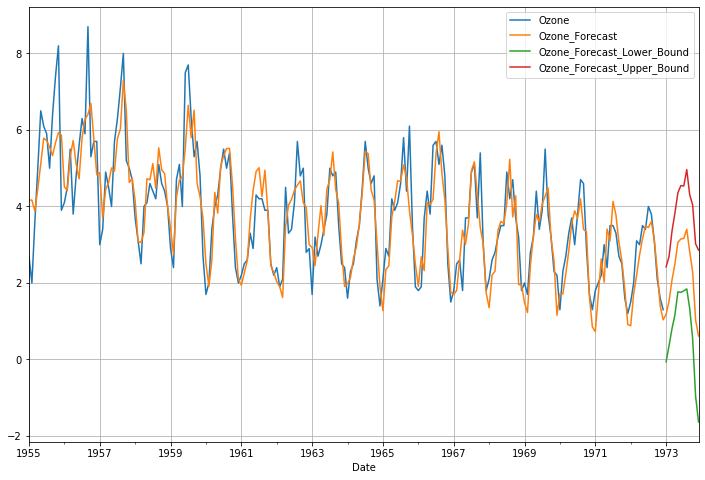

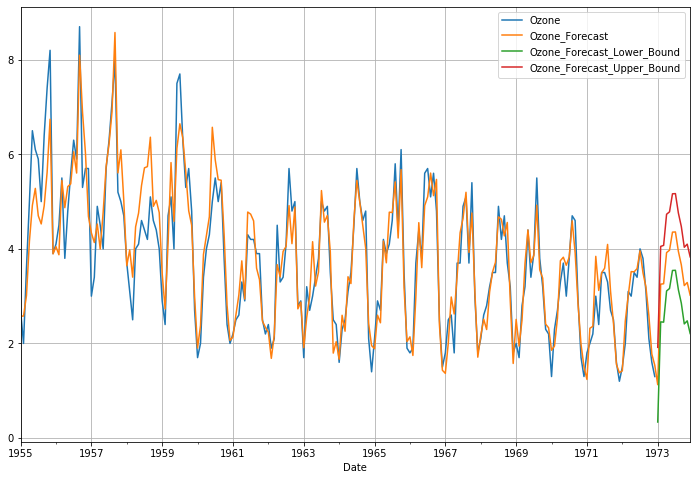

In [9]:
%matplotlib inline  
ozone_forecast_without_exog.plot.line('Date', ['Ozone' , 'Ozone_Forecast', 
                                             'Ozone_Forecast_Lower_Bound', 
                                             'Ozone_Forecast_Upper_Bound'], grid = True, figsize=(12, 8))
ozone_forecast_with_exog.plot.line('Date', ['Ozone' , 'Ozone_Forecast', 
                                             'Ozone_Forecast_Lower_Bound', 
                                             'Ozone_Forecast_Upper_Bound'], grid = True, figsize=(12, 8))